In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit

In [106]:
from qml.model.gate import get_gateset
from qml.model.unit import Unit, EmbedUnit
from qml.model.model import Model
from qml.tools.trainer import calc_gradients

In [133]:
nq = 2
nx = 1
ng = 3
gateset = get_gateset(nq)

In [144]:
model = Model(
    2, 1,
    EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset),
    [], Unit.generate_random_unit("tunit1", nq, ng, gateset),
)

In [109]:
xs = np.linspace(-1., 1., 30)
ps = [model.forward(x) for x in xs]

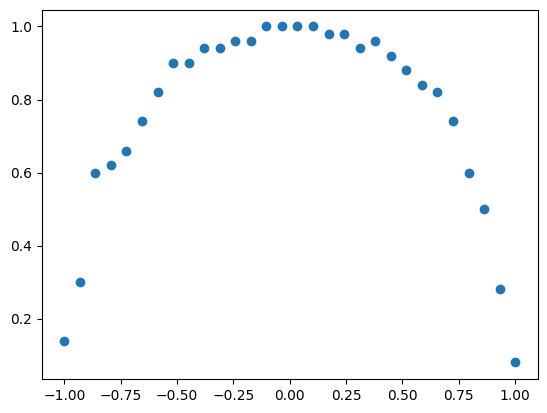

In [110]:
plt.scatter(xs, ps)

In [111]:
target_fn = lambda x: np.sin(np.pi * x)

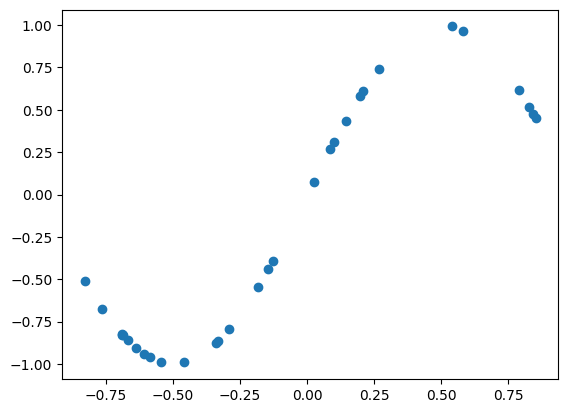

In [112]:
train_xs = np.random.uniform(-1, 1, 30)
train_ys = target_fn(train_xs)

test_xs = np.random.uniform(-1, 1, 50)
test_ys = target_fn(test_xs)

plt.scatter(train_xs, train_ys)
# plt.scatter(test_xs, test_ys)

In [113]:
class DataLoader:
    
    def __init__(self, xs, ys, num_batch: int, shuffle=True):
        assert len(xs) == len(ys)
        self._xs = np.asarray(xs)
        self._ys = np.asarray(ys)
        self.size = len(xs)
        self._num_batch = num_batch
        self._shuffle = shuffle
        self._idx = None
        self.iter_count = None
        
    def __iter__(self):
        self.iter_count = 0
        idx = np.arange(self.size)
        if self._shuffle:
            idx = np.random.permutation(idx)
        self._idx = [
            idx[i*self._num_batch:(i+1)*self._num_batch]
            for i in range(int(np.ceil(self.size / self._num_batch)))
        ]
        return self
    
    def __next__(self):
        if self.iter_count >= len(self._idx):
            raise StopIteration
        idx = self._idx[self.iter_count]
        bxs = self._xs[idx]
        bys = self._ys[idx]
        self.iter_count += 1
        return bxs, bys

In [114]:
lr = 1e-1

In [150]:
train_loader = DataLoader(train_xs, train_ys, num_batch=30, shuffle=True)

In [151]:
model.trainable_parameters

[array([6.268115586048062, 6.211345470942599, 6.18008688351722],
       dtype=object)]

In [152]:
for step in range(1, 30+1):
    epoch_loss = 0
    for batch_xs, batch_ys in train_loader:
        predicts = np.asarray([
            model.forward(x, shots=20)
            for x in batch_xs
        ])
        errors = batch_ys - predicts
        losses = 0.5 * np.square(errors)
        gradients = np.asarray([
            calc_gradients(model, x, shots=20)
            for x, y in zip(batch_xs, batch_ys)
        ])
        dparams = np.asarray([
            gradient * error
            for gradient, error in zip(gradients, errors)
        ]).mean(axis=0)
        new_params = np.asarray(model.trainable_parameters) - lr * dparams
        model.update_parameters(new_params)
        epoch_loss += losses.sum()
    epoch_loss /= train_loader.size
    print(f"step: {step: 3d},  loss: {epoch_loss:6.3f}")

step:   1,  loss:  0.707
step:   2,  loss:  0.743
step:   3,  loss:  0.778
step:   4,  loss:  0.705
step:   5,  loss:  0.756
step:   6,  loss:  0.795
step:   7,  loss:  0.742
step:   8,  loss:  0.711
step:   9,  loss:  0.758
step:  10,  loss:  0.759
step:  11,  loss:  0.767
step:  12,  loss:  0.731
step:  13,  loss:  0.775
step:  14,  loss:  0.756
step:  15,  loss:  0.756
step:  16,  loss:  0.707
step:  17,  loss:  0.807
step:  18,  loss:  0.754
step:  19,  loss:  0.765
step:  20,  loss:  0.801
step:  21,  loss:  0.726
step:  22,  loss:  0.833
step:  23,  loss:  0.789
step:  24,  loss:  0.733
step:  25,  loss:  0.778
step:  26,  loss:  0.720
step:  27,  loss:  0.773
step:  28,  loss:  0.750
step:  29,  loss:  0.743
step:  30,  loss:  0.789


In [146]:
xs = np.linspace(-1., 1., 30)
ps = [model.forward(x) for x in xs]

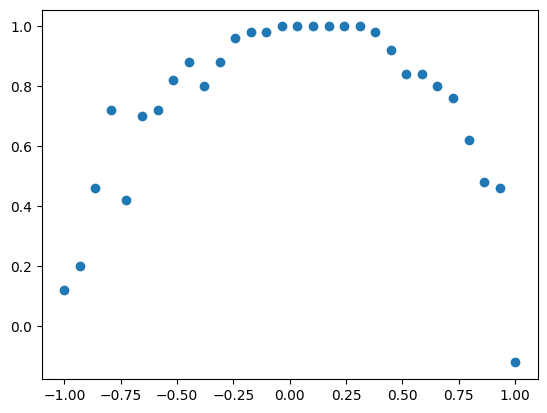

In [147]:
plt.scatter(xs, ps)

In [149]:
qc = QuantumCircuit(2)
model.input_units.apply_to_qc(qc)
model.trainable_units[0].apply_to_qc(qc)
qc.draw()

┌─────────────────┐┌────────────────────┐┌────────────────────┐
q_0: ┤ Ry(emb_param_0) ├┤ Rz(tunit1_param_1) ├┤ Ry(tunit1_param_2) ├
     ├─────────────────┤├────────────────────┤└────────────────────┘
q_1: ┤ Ry(emb_param_1) ├┤ Rz(tunit1_param_0) ├──────────────────────
     └─────────────────┘└────────────────────┘